In [1]:
# Import statements 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import string
import datetime
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import f1_score

In [2]:
# Load data
train_feats = pd.read_csv('train-dev-test/train_vax_cleaned.csv', delimiter=',', encoding="utf-8")
dev_feats = pd.read_csv('train-dev-test/dev_vax_cleaned.csv', delimiter=',', encoding="utf-8")
test_feats = pd.read_csv('train-dev-test/test_vax_cleaned.csv', delimiter=',', encoding="utf-8")

# Clear whitespace
train_feats.columns = train_feats.columns.str.strip()

In [3]:
# Dropping stuff!

# Drop all rows where time is NA?
print("Old length: ", len(train_feats))
train_feats = train_feats[train_feats['time'].notna()]
print("New length: ", len(train_feats))

# Just drop hashtags for now, too difficult for M3 to deal with
train_feats = train_feats.drop(['hashtags'], axis=1)

Old length:  195415
New length:  195415


In [4]:
# View the dataframes
train_feats.head(5)
#train_feats.columns                                        

,Unnamed: 0,text,place,user_location,followers_count,retweet_count,favorite_count,weekday,month,day,...,num_present,trump_present,hashtag_present,covid,vaccine,profanity_present,emoji_present,url_present,question_exclamation_present,sentiment
0,145,@letdwn666 @prisonweddingg Bro thx for sharing...,NaN,NaN,632,0,0,Thu,Mar,19.0,...,True,False,False,True,True,False,False,False,False,neutral
1,228,“Is there a corona virus? NO it may possibly b...,NaN,NaN,72,0,0,Thu,Mar,19.0,...,True,False,False,True,True,False,False,True,True,neutral
2,394,"@drharshvardhan Sir,\nCorona symptoms looking ...",NaN,"Pune, Maharashtra",4,0,0,Thu,Mar,19.0,...,True,False,False,True,True,False,False,False,True,neutral
3,470,Snakes who speaks from both side of there mout...,NaN,Lagos,190,0,0,Thu,Mar,19.0,...,True,False,False,False,True,False,False,True,False,neutral
4,630,The inventor of the Corona virus vaccine shoul...,NaN,bombay,36,0,0,Thu,Mar,19.0,...,True,False,True,True,True,False,False,False,False,neutral


In [5]:
train_feats.dtypes

Unnamed: 0                        int64
text                             object
place                            object
user_location                    object
followers_count                   int64
retweet_count                     int64
favorite_count                    int64
weekday                          object
month                            object
day                             float64
time                             object
year                            float64
num_present                        bool
trump_present                      bool
hashtag_present                    bool
covid                              bool
vaccine                            bool
profanity_present                  bool
emoji_present                      bool
url_present                        bool
question_exclamation_present       bool
sentiment                        object
dtype: object

In [6]:
# Feature manipulation to make them ready for the model
# Change sentiment labels to numbers!
train_feats['sentiment'] = train_feats['sentiment'].astype('category')
train_feats["sentiment"] = train_feats["sentiment"].cat.codes

# Change location
train_feats["user_location"] = train_feats["user_location"].astype('category')
train_feats["user_location"] = train_feats["user_location"].cat.codes

# Change place
train_feats["place"] = train_feats["place"].astype('category')
train_feats["place"] = train_feats["place"].cat.codes

# Change weekday
#train_feats["weekday"] = train_feats["weekday"].astype('category')
#train_feats["weekday"] = train_feats["weekday"].cat.codes

# Change month
train_feats["month"] = train_feats["month"].astype('category')
train_feats["month"] = train_feats["month"].cat.codes

# Change time to datetime object
#train_feats['time'] = train_feats['time'].apply(lambda x: datetime.datetime.strptime(str(x), '%H:%M:%S'))

# Add hour and minute columns
#train_feats['hour'] = train_feats['time'].apply(lambda x: x.hour)
#train_feats['minute'] = train_feats['time'].apply(lambda x: x.minute)

# Drop time
train_feats = train_feats.drop(['time'], axis=1)

# Change all the bool types to numeric
train_feats["num_present"] = train_feats["num_present"].astype(int)
train_feats["trump_present"] = train_feats["trump_present"].astype(int)
#train_feats["hashtag_present"] = train_feats["hashtag_present"].astype(int)
train_feats["covid"] = train_feats["covid"].astype(int)
train_feats["vaccine"] = train_feats["vaccine"].astype(int)
train_feats["profanity_present"] = train_feats["profanity_present"].astype(int)
#train_feats["emoji_present"] = train_feats["emoji_present"].astype(int)
train_feats["url_present"] = train_feats["url_present"].astype(int)
#train_feats["question_exclamation_present"] = train_feats["question_exclamation_present"].astype(int)

In [7]:
train_feats.head(2)

,Unnamed: 0,text,place,user_location,followers_count,retweet_count,favorite_count,weekday,month,day,...,num_present,trump_present,hashtag_present,covid,vaccine,profanity_present,emoji_present,url_present,question_exclamation_present,sentiment
0,145,@letdwn666 @prisonweddingg Bro thx for sharing...,-1,-1,632,0,0,Thu,6,19.0,...,1,0,False,1,1,0,False,0,False,1
1,228,“Is there a corona virus? NO it may possibly b...,-1,-1,72,0,0,Thu,6,19.0,...,1,0,False,1,1,0,False,1,True,1


In [8]:
# Start the Unsupervised stuff in this cell!

import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [9]:
# Load the regular expression library
import re
# Remove punctuation
train_feats['text'] = \
train_feats['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
train_feats['text'] = \
train_feats['text'].map(lambda x: x.lower())
# Print out the first rows of papers
train_feats['text'].head()

0    @letdwn666 @prisonweddingg bro thx for sharing...
1    “is there a corona virus no it may possibly be...
2    @drharshvardhan sir\ncorona symptoms looking 7...
3    snakes who speaks from both side of there mout...
4    the inventor of the corona virus vaccine shoul...
Name: text, dtype: object

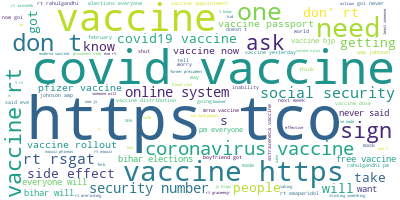

In [11]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(train_feats['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [30]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'tco', 'rt', 'don\'', 'rsgt', 't', 'vaccine',
'vaccines', 'amp', 'covid'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = train_feats.text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/varunramakrishnan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['letdwn', 'prisonweddingg', 'bro', 'thx', 'sharing', 'corona', 'virus', 'owe', 'life']


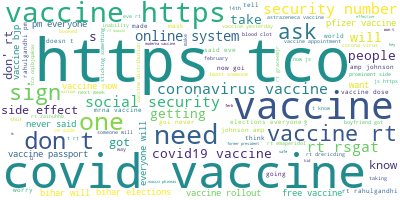

In [32]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(train_feats['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [33]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [34]:
from pprint import pprint
# number of topics
num_topics = 6
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"get" + 0.010*"says" + 0.009*"people" + 0.009*"pfizer" + '
  '0.006*"coronavirus" + 0.006*"worry" + 0.005*"india" + 0.005*"us" + '
  '0.005*"take" + 0.005*"states"'),
 (1,
  '0.011*"johnson" + 0.010*"pfizer" + 0.008*"doses" + 0.007*"people" + '
  '0.007*"take" + 0.006*"trump" + 0.005*"first" + 0.004*"coronavirus" + '
  '0.004*"new" + 0.004*"get"'),
 (2,
  '0.015*"pfizer" + 0.011*"getting" + 0.011*"moderna" + 0.007*"dose" + '
  '0.006*"like" + 0.006*"first" + 0.006*"passports" + 0.006*"mrna" + '
  '0.005*"one" + 0.005*"safe"'),
 (3,
  '0.009*"get" + 0.008*"pfizer" + 0.007*"people" + 0.006*"least" + '
  '0.006*"government" + 0.005*"someone" + 0.005*"th" + 0.005*"doses" + '
  '0.005*"us" + 0.005*"good"'),
 (4,
  '0.047*"get" + 0.021*"one" + 0.019*"need" + 0.017*"everyone" + '
  '0.016*"social" + 0.016*"number" + 0.016*"system" + 0.015*"sign" + '
  '0.015*"security" + 0.015*"online"'),
 (5,
  '0.017*"got" + 0.013*"would" + 0.009*"made" + 0.009*"virus" + 0.008*"people" '
  '+ 

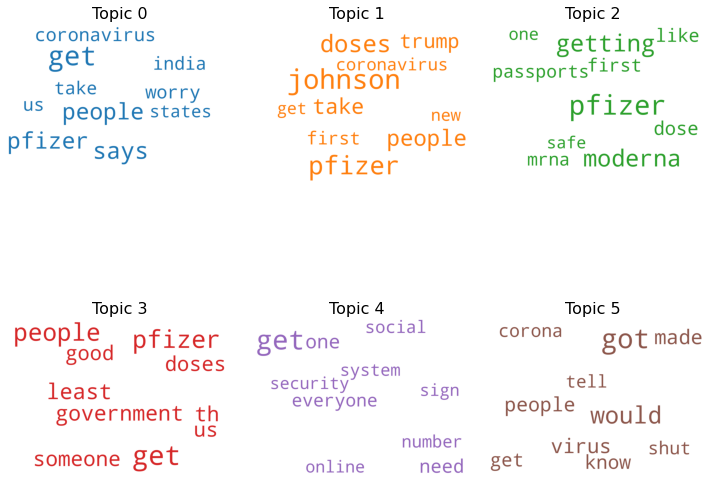

In [35]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [19]:
all_text = train_feats['text'].tolist()

vectorizer = TfidfVectorizer(max_features=100, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(all_text).toarray()

In [20]:
# Drop text (JUST FOR A TEST)
train_feats = train_feats.drop(['text'], axis=1)
train_feats = train_feats.drop(['weekday'], axis=1)

In [29]:
# Get data ready
# Get sentiment
labels = train_feats['sentiment']
# Drop labels from larger dataframee
train_feats = train_feats.drop(['sentiment'], axis=1)

# Convert both to numpy arrays
#non_text_feats = train_feats.to_numpy()
#X = np.concatenate((processed_features, non_text_feats), axis=1)
X = processed_features
y = labels.to_numpy()

KeyError: 'sentiment'

In [30]:
# Instantiate model - Multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train model
model.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [31]:
y_preds = model.predict(X)
# Print score
print(f1_score(y, y_preds, average='micro'))

0.6274510473219177
